# 【第51回_Beginner限定コンペ】債務不履行リスクの低減

債務不履行（デフォルト）リスクの予測モデルでは、通常、クラス不均衡（デフォルトする人の数が非常に少ない）などの課題があり、精度やAUC、リコールなどの指標が重要になります。このような課題に対処するために、LightGBMとOptunaを使ってパラメータの最適化を行う際に考慮すべきポイントを説明します。  
- ChargedOff(債務不履行)を1、FullyPaid(債務履行済み)を0として予測
- 評価基準：F1 Score

- 評価関数「F1Score」
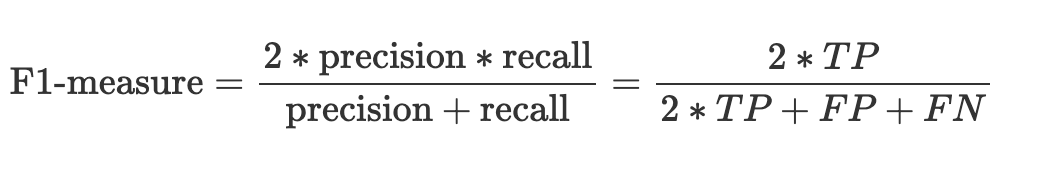  
    - 適合率と再現率の調和平均
    - 評価値は0～1の値をとり、精度が高いほど大きな値
    - 今回運営の設定するTier変更の閾値はF1Score=0.3739669

    

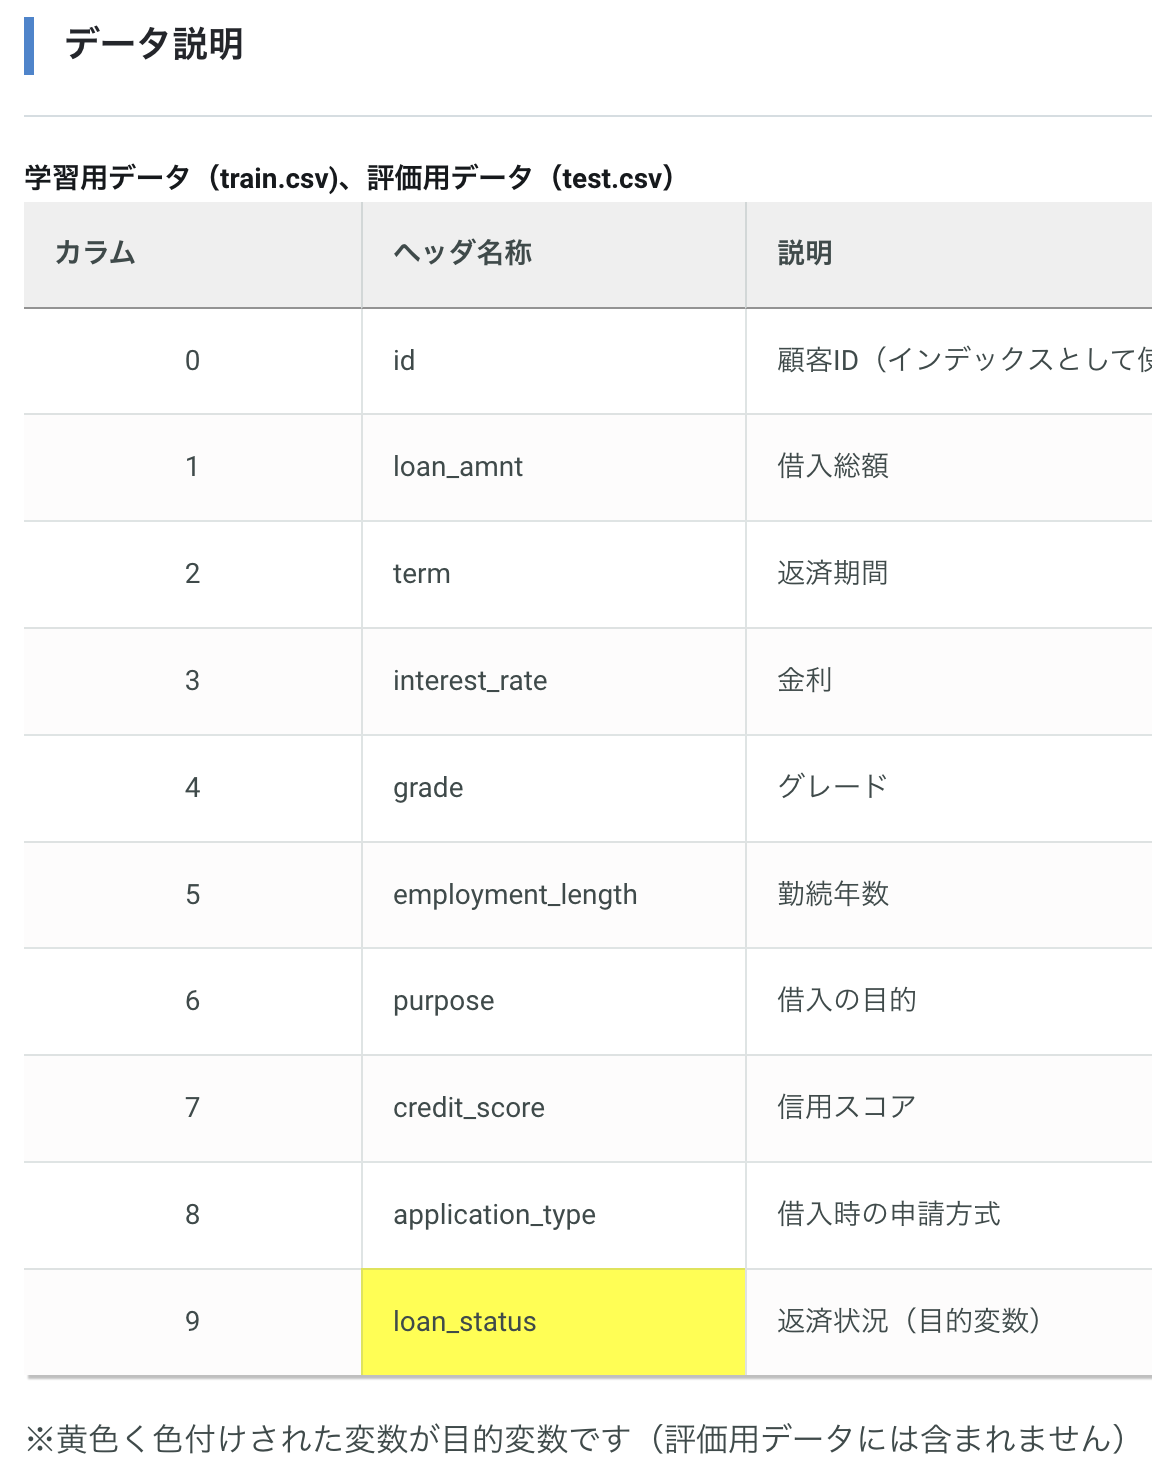

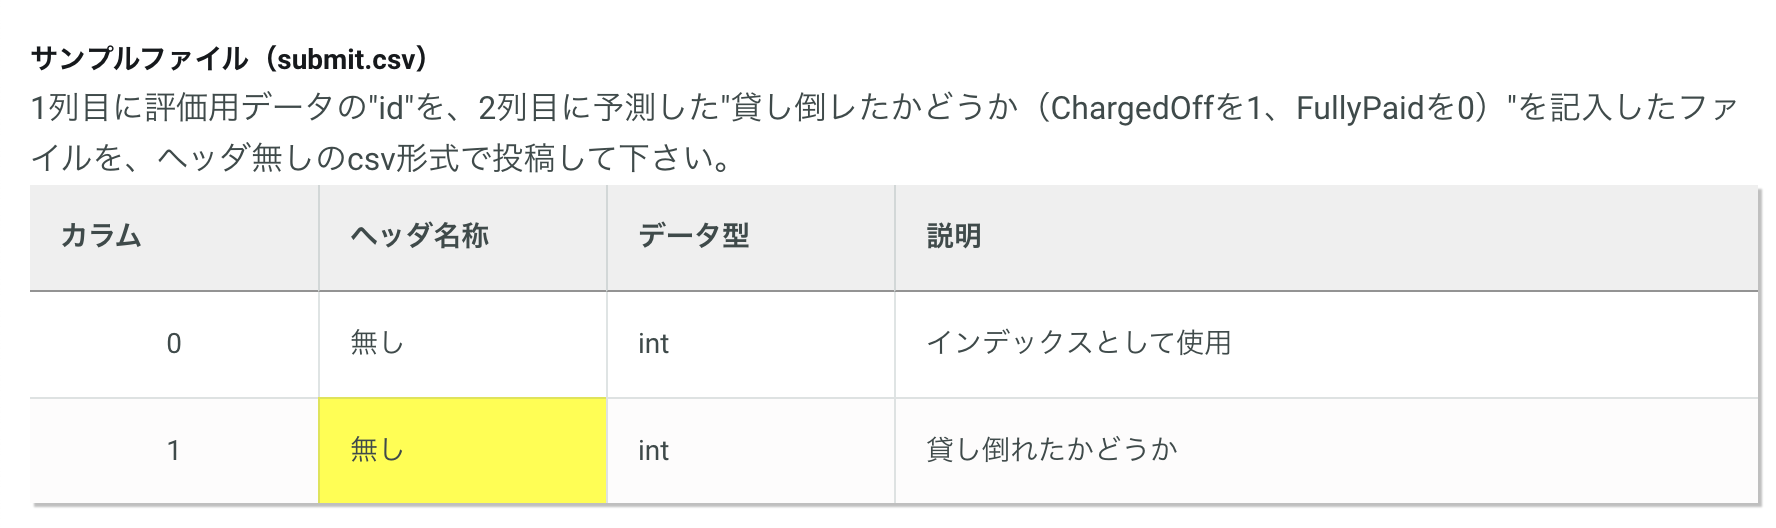

## データの特徴

- col:10, len:242150
- データの型はint, float, objectが混合
- 欠損なし
- 強い相関を持つ特徴量はない
- 不均衡（デフォルトしないケースが多数で、デフォルトするケースが少ない場合）
    - optunaにscale_pos_weight追加  
各特徴量について  
- FullyPaidの数がChargedOffの数の3倍以上
- 量的データについては各特徴量において値が小さなデータの量が多く、値が大きくなるにつれてデータ量は減る傾向にある
- 金利(interest_rate)が上がると債務不履行が増加
- 信用スコア（credit_score）が高いと債務不履行が若干減少
- termは3,5年の２種類のみ（train,test両方）

## 実施内容

### 前処理
必ず行うこと
- 削除
    - ID
- 数値型への変換    
    - term:単位の確認、yearの削除
    - employment_length:単位の確認、yearの削除
- One-Hot Encoding
    - grade
    - purpose
    - application_type
    - loan_status  
    
追加で行ったこと
- 特徴量生成
    - grade:A~Eで一括りにする
    - 
- (標準化、正規化)

## やること

- ベースモデルの作成（線形モデル,ディープラーニング、ランダムフォレスト、XGBoost、SVM...）
- 各特徴量の分布の確認、相関の確認(外れ値の確認)
- ドメインによる相関の確認

- 特徴量選択や組み合わせができるか確認（ここまでは説明性重視）
- 不均衡データ
    - アンダーサンプリング:多い方のクラスのデータをサンプリングして減らすことでデータを均衡させる方法である。利用できるデータが減ってしまうため、異なる乱数でアンダーサンプリングしたデータを用いてバギングを行うことが多い。私の経験では、学習に利用できる計算資源の制約を上回る程のデータがある場合は、実装が容易なアンダーサンプリングを行うことが多い。
    - 重みづけは:lossを計算する際に、サンプルやクラス毎に重みを設定する方法である。主要な学習ライブラリでは重みづけをサポートしていることが多い。
- モデルのパラメータチューニング、選択、スタッキング（モデルの精度向上重視）

済み  


# コード

## 　ライブラリ

In [146]:
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

import optuna
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import f1_score

# pd.set_option("display.max_columns", 50)
# pd.set_option("display.max_rows", 50)

In [92]:
np.random.seed(42)
random.seed(42)

## データの確認
- 質的変数
    - 名義尺度
    - 順序尺度
- 量的変数
    - 間隔尺度
    - 比例尺度

In [93]:
train_df = pd.read_csv('./input/train.csv')
test_df = pd.read_csv('./input/test.csv')
submit_df = pd.read_csv('./input/submit.csv', header=None)

In [4]:
train_df.head()

,id,loan_amnt,term,interest_rate,grade,employment_length,purpose,credit_score,application_type,loan_status
0,0,609.296068,3 years,8.421982,A5,0 years,debt_consolidation,714.061803,Individual,FullyPaid
1,1,1183.266999,5 years,10.286776,B1,10 years,credit_card,697.706701,Individual,ChargedOff
2,2,695.783256,3 years,14.723425,C2,1 year,debt_consolidation,656.419357,Individual,FullyPaid
3,3,738.392546,3 years,14.260708,C1,0 years,credit_card,657.906852,Individual,FullyPaid
4,4,1642.400654,5 years,25.217452,E5,10 years,debt_consolidation,662.972297,Individual,FullyPaid


In [ ]:
train_df.isnull().sum()

id                   0
loan_amnt            0
term                 0
interest_rate        0
grade                0
employment_length    0
purpose              0
credit_score         0
application_type     0
loan_status          0
dtype: int64

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242150 entries, 0 to 242149
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 242150 non-null  int64  
 1   loan_amnt          242150 non-null  float64
 2   term               242150 non-null  object 
 3   interest_rate      242150 non-null  float64
 4   grade              242150 non-null  object 
 5   employment_length  242150 non-null  object 
 6   purpose            242150 non-null  object 
 7   credit_score       242150 non-null  float64
 8   application_type   242150 non-null  object 
 9   loan_status        242150 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 18.5+ MB


In [10]:
train_df.describe()

,id,loan_amnt,interest_rate,credit_score
count,242150.00000,242150.000000,242150.000000,242150.000000
mean,121074.50000,1520.389009,13.801496,683.575024
std,69902.82818,830.250197,4.588924,29.554795
min,0.00000,323.797279,5.704849,655.424269
25%,60537.25000,761.954545,10.876086,659.531106
50%,121074.50000,1212.680586,13.543833,678.672563
75%,181611.75000,2152.213330,17.172395,698.591960
max,242149.00000,3851.867974,27.980604,808.551641


In [8]:
train_df.astype("str").describe()

,id,loan_amnt,term,interest_rate,grade,employment_length,purpose,credit_score,application_type,loan_status
count,242150,242150,242150,242150,242150,242150,242150,242150,242150,242150
unique,242150,241705,2,241973,27,11,9,240708,2,2
top,0,698.4295424499581,3 years,14.815611829321716,C4,10 years,debt_consolidation,698.0537805885727,Individual,FullyPaid
freq,1,3,189887,2,18936,103339,160207,3,240368,199794


In [15]:
train_df.corr(numeric_only=True)

,id,loan_amnt,interest_rate,credit_score
id,1.000000,0.001381,-0.002235,0.001604
loan_amnt,0.001381,1.000000,0.210790,0.098274
interest_rate,-0.002235,0.210790,1.000000,-0.443101
credit_score,0.001604,0.098274,-0.443101,1.000000


In [44]:
col_lists = train_df.columns.to_list()

for col in col_lists:
    print(train_df[col].value_counts())
    print('==========================================================')

id
0         1
161438    1
161426    1
161427    1
161428    1
         ..
80720     1
80721     1
80722     1
80723     1
242149    1
Name: count, Length: 242150, dtype: int64
loan_amnt
698.429542     3
2281.711256    2
1176.782193    2
1144.486899    2
2318.346176    2
              ..
3598.159595    1
677.277718     1
2236.483684    1
2229.439169    1
2464.766281    1
Name: count, Length: 241705, dtype: int64
term
3 years    189887
5 years     52263
Name: count, dtype: int64
interest_rate
14.815612    2
14.695510    2
10.684984    2
19.050507    2
13.191068    2
            ..
11.063027    1
14.233826    1
7.197906     1
18.877091    1
17.052682    1
Name: count, Length: 241973, dtype: int64
grade
C4    18936
B4    18409
C1    16767
B2    16357
B3    16058
B1    15484
B5    15163
C2    13917
C5    11420
A5    10785
D1    10464
C3    10266
D4     9828
A4     9441
D2     8823
D3     8387
D5     6866
A3     6532
A1     5764
A2     5749
E2     2835
E4     2301
E1      640
E5      535
E3

In [208]:
pd.pivot_table(train_df, index='grade', columns='loan_status', values='id')

loan_status,ChargedOff,FullyPaid
grade,,
A1,125687.321429,121263.193101
A2,126278.068966,120481.192634
A3,119530.608416,121029.874922
A4,118011.930769,121929.310279
A5,119706.507538,121780.115433
B1,119278.505469,122241.816687
B2,122031.338914,120832.898164
B3,120149.795469,120399.944433
B4,119430.933038,121452.175065


In [196]:
# 量的変数、質的変数ごとにデータを分離
col_categoric = ["term", "grade", "employment_length", "purpose" , "application_type", "loan_status"]
df_numeric = train_df.drop(col_categoric, axis=1)
df_categoric = train_df[col_categoric]

df_tmp = pd.concat([df_categoric["loan_status"], df_numeric], axis=1)

/Users/ishidzukamasato/.pyenv/versions/3.11.3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ishidzukamasato/.pyenv/versions/3.11.3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/ishidzukamasato/.pyenv/versions/3.11.3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/ishid

<Axes: xlabel='grade', ylabel='Count'>

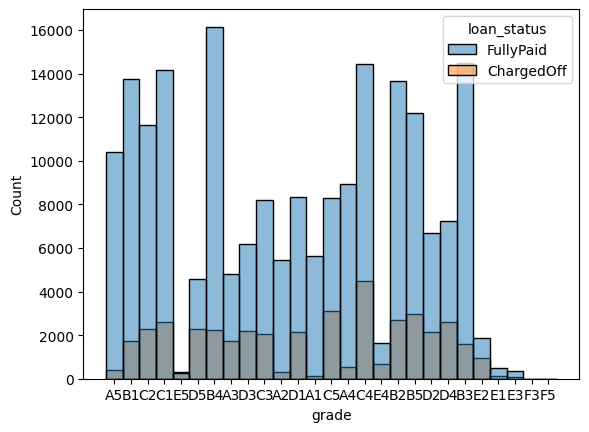

In [220]:
sns.histplot(data=df_categoric,x='grade' , hue='loan_status')

/Users/ishidzukamasato/.pyenv/versions/3.11.3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ishidzukamasato/.pyenv/versions/3.11.3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/ishidzukamasato/.pyenv/versions/3.11.3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/ishid

<Axes: xlabel='employment_length', ylabel='Count'>

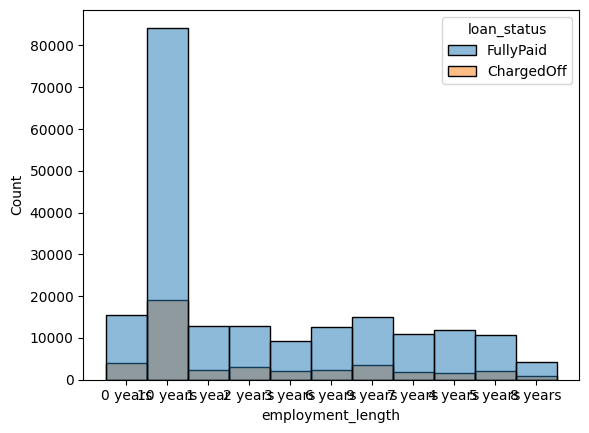

In [221]:
sns.histplot(data=df_categoric,x='employment_length' , hue='loan_status')

/Users/ishidzukamasato/.pyenv/versions/3.11.3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ishidzukamasato/.pyenv/versions/3.11.3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/ishidzukamasato/.pyenv/versions/3.11.3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/ishid

<Axes: xlabel='purpose', ylabel='Count'>

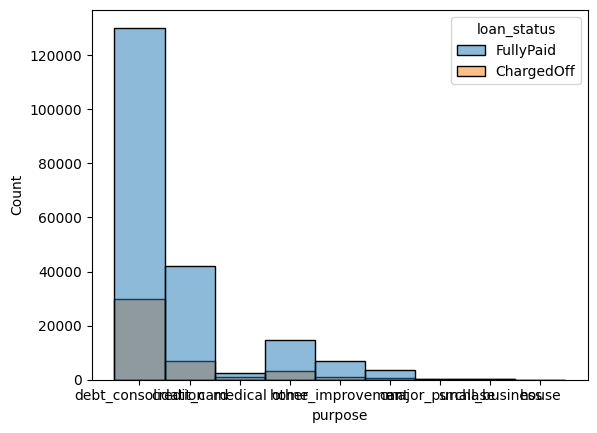

In [222]:
sns.histplot(data=df_categoric,x='purpose' , hue='loan_status')

array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'loan_amnt'}>],
       [<Axes: title={'center': 'interest_rate'}>,
        <Axes: title={'center': 'credit_score'}>]], dtype=object)

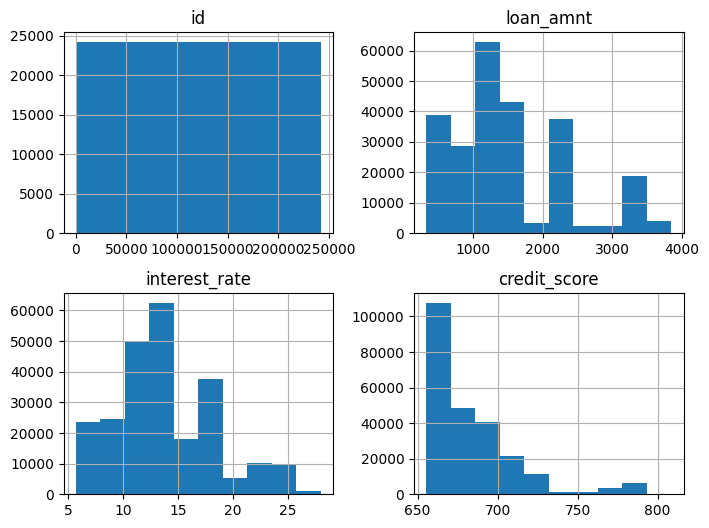

In [195]:
df_numeric.hist(figsize=(8,6))


In [203]:
df_tmp

,loan_status,id,loan_amnt,interest_rate,credit_score
0,FullyPaid,0,609.296068,8.421982,714.061803
1,ChargedOff,1,1183.266999,10.286776,697.706701
2,FullyPaid,2,695.783256,14.723425,656.419357
3,FullyPaid,3,738.392546,14.260708,657.906852
4,FullyPaid,4,1642.400654,25.217452,662.972297
...,...,...,...,...,...
242145,FullyPaid,242145,2427.939262,13.673803,657.206417
242146,ChargedOff,242146,1224.346665,11.793595,699.763028
242147,FullyPaid,242147,2089.513458,8.218123,724.556339
242148,FullyPaid,242148,3459.367114,14.875958,688.249378


/var/folders/9w/zx7s1ndd7tx4ccd0jcmnz9wm0000gn/T/ipykernel_8430/3248513873.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_tmp.query("loan_status=='FullyPaid'")[colname])
/Users/ishidzukamasato/.pyenv/versions/3.11.3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/9w/zx7s1ndd7tx4ccd0jcmnz9wm0000gn/T/ipykernel_8430/3248513873.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.


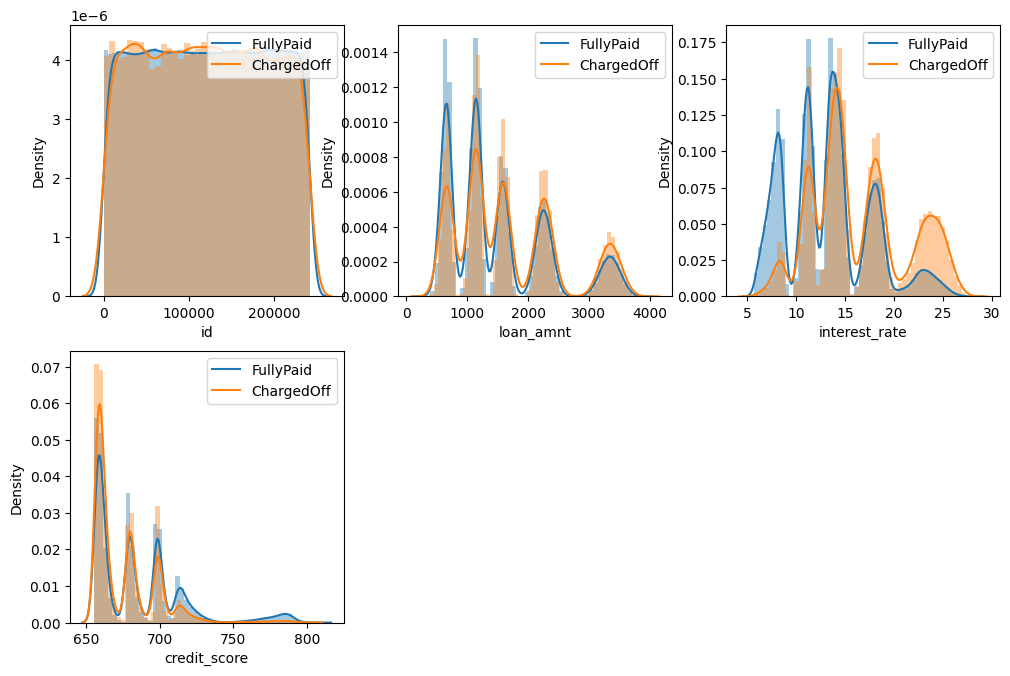

In [205]:
# グラフの整形
plt.figure(figsize=(12, 12))

for ncol, colname in enumerate(df_numeric.columns):
    plt.subplot(3, 3, ncol+1) # plt.subplot(縦のプロット数, 横のプロット数, プロット番号)
    sns.distplot(df_tmp.query("loan_status=='FullyPaid'")[colname])
    sns.distplot(df_tmp.query("loan_status=='ChargedOff'")[colname]) 
    plt.legend(labels=["FullyPaid", "ChargedOff"], loc='upper right') 

## データの前処理

In [94]:
all_df = pd.concat([train_df, test_df], sort=False).reset_index(drop=True)

In [104]:
pre_all_df = all_df.copy()

In [105]:
# id:削除
pre_all_df = pre_all_df.drop("id", axis=1)

In [106]:
# 文字列から数字部分を抽出して数値型に変換
pre_all_df['term'] = pre_all_df['term'].astype(str).str.extract('(\d+)').astype(int)
pre_all_df['employment_length'] = pre_all_df['employment_length'].astype(str).str.extract('(\d+)').astype(int)

In [107]:
# 目的変数の数値化
pre_all_df['loan_status'] = pre_all_df['loan_status'].replace({'ChargedOff': 1, 'FullyPaid': 0})

/var/folders/9w/zx7s1ndd7tx4ccd0jcmnz9wm0000gn/T/ipykernel_8430/285381003.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pre_all_df['loan_status'] = pre_all_df['loan_status'].replace({'ChargedOff': 1, 'FullyPaid': 0})


In [108]:
pre_all_df.describe()

,loan_amnt,term,interest_rate,employment_length,credit_score,loan_status
count,269050.000000,269050.000000,269050.000000,269050.000000,269050.000000,242150.000000
mean,1519.859753,3.431823,13.799192,6.675135,683.601549,0.174916
std,829.996603,0.822908,4.588799,3.655455,29.567969,0.379896
min,323.797279,3.000000,5.704849,0.000000,655.424269,0.000000
25%,761.018388,3.000000,10.873094,3.000000,659.537311,0.000000
50%,1212.796960,3.000000,13.544496,9.000000,678.675610,0.000000
75%,2151.594482,3.000000,17.168621,10.000000,698.601175,0.000000
max,3851.867974,5.000000,27.980604,10.000000,811.676356,1.000000


In [109]:
pre_all_df.corr(numeric_only=True)

,loan_amnt,term,interest_rate,employment_length,credit_score,loan_status
loan_amnt,1.000000,0.345155,0.211136,0.065900,0.097567,0.085033
term,0.345155,1.000000,0.463514,0.029441,-0.028029,0.167006
interest_rate,0.211136,0.463514,1.000000,0.000589,-0.443182,0.270212
employment_length,0.065900,0.029441,0.000589,1.000000,0.040409,0.008040
credit_score,0.097567,-0.028029,-0.443182,0.040409,1.000000,-0.126770
loan_status,0.085033,0.167006,0.270212,0.008040,-0.126770,1.000000


### 可視化(One-Hot Encoding前)

/Users/ishidzukamasato/.pyenv/versions/3.11.3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ishidzukamasato/.pyenv/versions/3.11.3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/ishidzukamasato/.pyenv/versions/3.11.3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/ishid

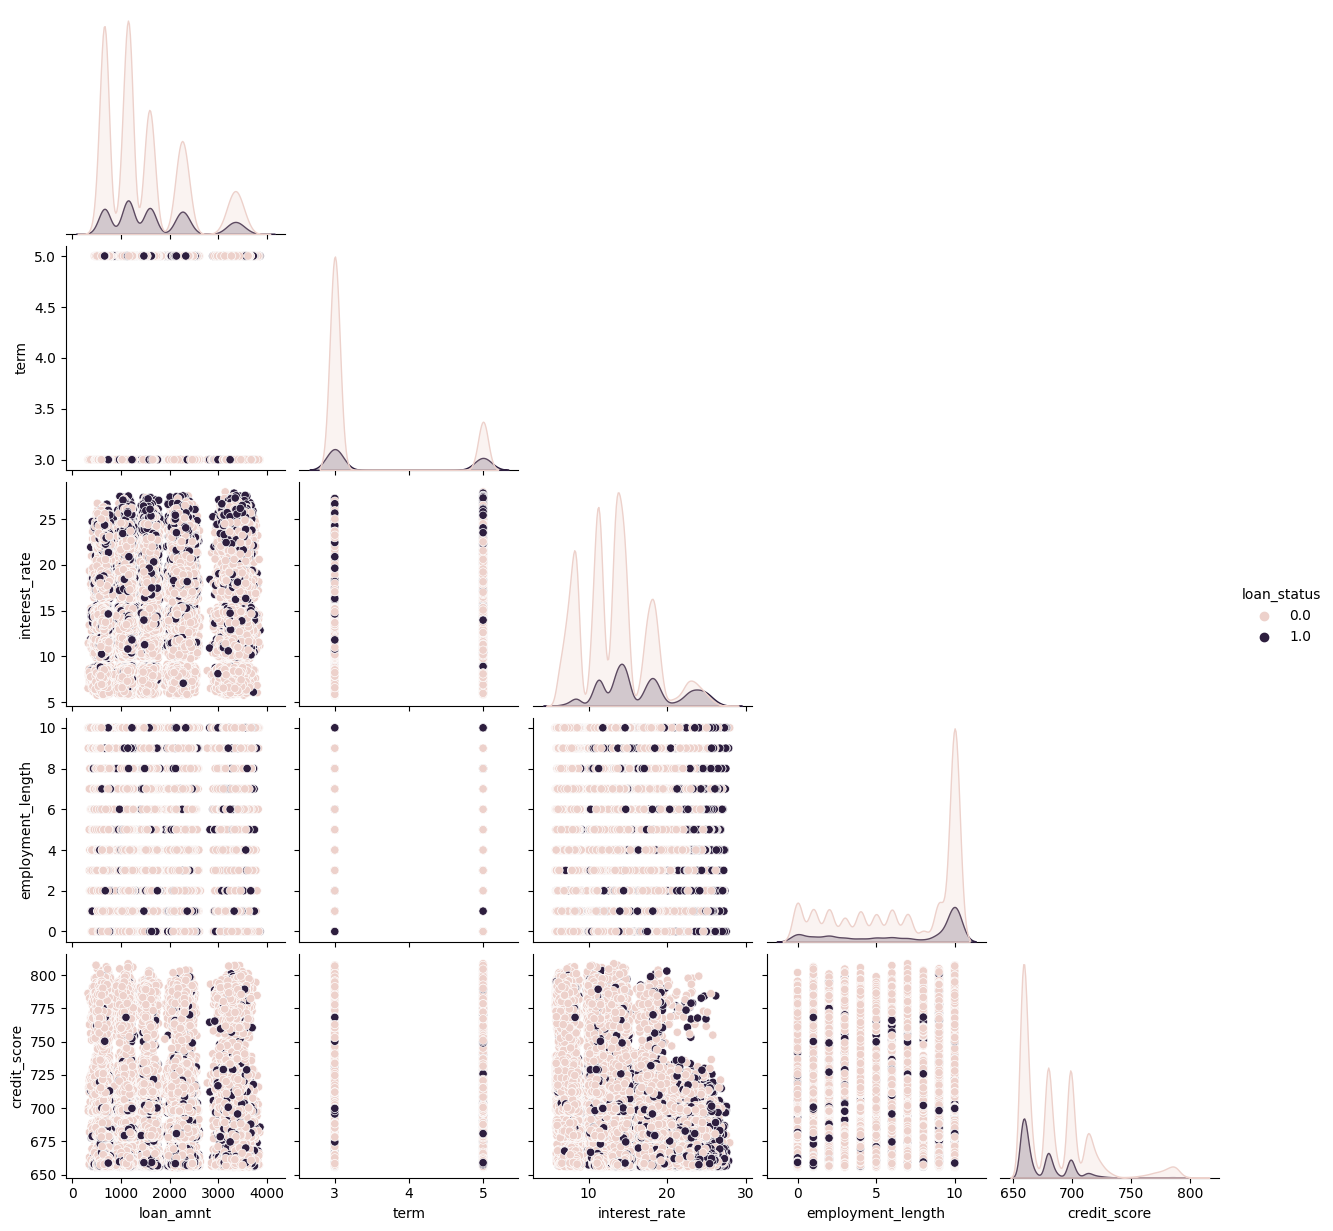

In [110]:
sns.pairplot(data=pre_all_df, corner=True, hue='loan_status')

/Users/ishidzukamasato/.pyenv/versions/3.11.3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ishidzukamasato/.pyenv/versions/3.11.3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/ishidzukamasato/.pyenv/versions/3.11.3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='grade', ylabel='Count'>

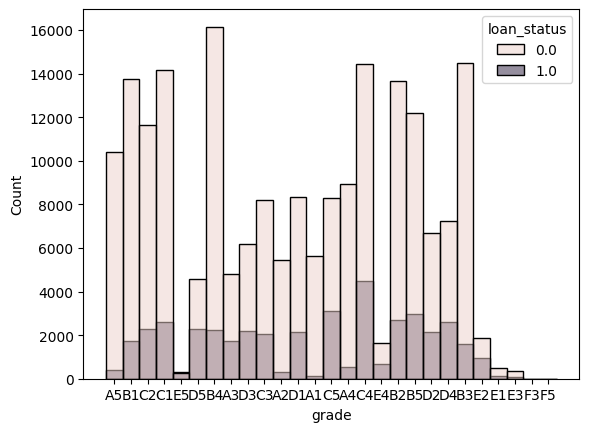

In [111]:
sns.histplot(pre_all_df, x="grade", hue="loan_status")

### カテゴリデータの変換
- One-Hot Encoding（名義尺度）
    - purpose
    - application_type
- （順序尺度）
    - grade

In [112]:
categories = pre_all_df.columns[pre_all_df.dtypes == "object"]

for cat in categories:
    pre_all_df = pd.get_dummies(pre_all_df, columns=[cat], drop_first=True, dtype=int)

In [113]:
pre_all_df.head()

,loan_amnt,term,interest_rate,employment_length,credit_score,loan_status,grade_A2,grade_A3,grade_A4,grade_A5,...,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,application_type_Joint App
0,609.296068,3,8.421982,0,714.061803,0.0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
1,1183.266999,5,10.286776,10,697.706701,1.0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,695.783256,3,14.723425,1,656.419357,0.0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,738.392546,3,14.260708,0,657.906852,0.0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,1642.400654,5,25.217452,10,662.972297,0.0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


### 追加の前処理
- Interaction Features（交互作用特徴量）: 2つの特徴量を掛け合わせることで、関係性を強化します。
- Polynomial Features（多項式特徴量）: 元の特徴量を2次や3次に拡張することで、非線形関係を捉えます。
- Log Transform（対数変換）: 対数を取ることで、異常なスケールの特徴量を改善します。
- Target Encoding（ターゲットエンコーディング）: カテゴリ変数に対して、目的変数の平均を使ったエンコーディング

In [ ]:
# 特徴量間の掛け算（Interaction Features）
data['feature1_feature2_interaction'] = data['feature1'] * data['feature2']

# 対数変換（Log Transform）
data['log_feature1'] = np.log1p(data['feature1'])  # 0値対応のためlog1pを使用

# 多項式特徴量の生成（Polynomial Features）
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False)
data_poly = poly.fit_transform(data[['feature1', 'feature2']])


In [ ]:
# 標準化、正規化(fitはtrainデータに対してのみ行う)

# 数値データのスケーリング
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)


In [ ]:
>>> size_mapping = {'XL': 3, 'L': 2, 'M': 1}
>>> # Tシャツのサイズを整数に変換
>>> df['size'] = df['size'].map(size_mapping)
>>> df
   color  size  price classlabel
0  green     1   10.1     class2
1    red     2   13.5     class1
2   blue     3   15.3     class2


### 可視化(One-Hot Encoding後)

## モデル構築

In [141]:
train_X = pre_all_df[~pre_all_df["loan_status"].isnull()].drop("loan_status", axis=1).reset_index(drop=True)
train_y = pre_all_df[~pre_all_df["loan_status"].isnull()]["loan_status"]

test_X = pre_all_df[pre_all_df["loan_status"].isnull()].drop("loan_status", axis=1).reset_index(drop=True)

債務不履行予測モデルに適したパラメータ設定
objective:

推奨設定: binary
理由: デフォルトか否かという二値分類タスクなので、binaryを使用します。
metric:

推奨設定: auc
理由: デフォルト予測では、正解率だけでなく、ROC AUC（正例と負例を正しく区別する能力）が重要です。クラス不均衡な場合、accuracyはあまり意味がなく、aucやprecision, recallの方が有効です。
boosting_type:

推奨設定: gbdt
理由: 標準の勾配ブースティングを使うのが最も一般的です。必要に応じて、dartやgossも試しても良いですが、通常はgbdtが良い結果を出します。
learning_rate:

推奨範囲: 0.001から0.1
理由: 学習率は慎重に設定する必要があります。値が小さいほど、ゆっくりとした学習になり、より正確な結果を得やすいです。Optunaでログスケールの範囲を設定し、探索させます。
num_leaves:

推奨範囲: 20から150
理由: 大きすぎる値は過学習を招くため、データの規模に応じた適切な範囲を探索します。
min_data_in_leaf:

推奨範囲: 20から100
理由: 葉に含まれる最小データ数を増やすことで、モデルの複雑さを抑え、過学習を防ぎます。
feature_fraction:

推奨範囲: 0.4から0.9
理由: 各イテレーションで使用する特徴量の割合を制限することで、モデルの汎化性能を向上させます。クラス不均衡データでは、汎化性能を高めるためにサブサンプリングが有効です。
bagging_fraction:

推奨範囲: 0.4から0.9
理由: 同様にデータサブサンプリングも行うことで、過学習を防ぎ、モデルのロバスト性を向上させます。
bagging_freq:

推奨範囲: 1から7
理由: バギング（サンプリング）の頻度を決めます。データサブサンプリングを効果的に活用するためには、頻繁にバギングを行うのが良いでしょう。
max_depth:

推奨範囲: 5から15
理由: 木の最大深さを制限することで、過学習を防ぎます。デフォルト予測のような場合、木の深さを制限しすぎると複雑なパターンを捉えきれない可能性がありますが、深すぎると過学習のリスクが高まります。
lambda_l1（L1正則化）:

推奨範囲: 1e-8から10
理由: L1正則化はスパースなモデル（不要な特徴量を排除する）に役立ちます。クラス不均衡な場合でも、特徴量の中にはあまり役立たないものが含まれている可能性があるため、L1正則化で不要なものを排除します。
lambda_l2（L2正則化）:

推奨範囲: 1e-8から10
理由: L2正則化はパラメータの大きさを抑制し、過学習を防ぎます。特に複雑なモデルを作りすぎないようにするために役立ちます。
クラス不均衡対策 (scale_pos_weight):

推奨範囲: 1.0からn, ここでnは負例の数 / 正例の数
理由: クラス不均衡を補正するために、scale_pos_weightを設定します。デフォルトしないケースが多数で、デフォルトするケースが少ない場合、この値を大きく設定することで、正例（デフォルト）に重点を置いた学習ができます。

In [152]:
# カスタム評価関数の定義（f1スコアを評価に使用）
def f1_eval(preds, data):
    labels = data.get_label()
    preds = np.round(preds)  # 0か1に変換
    return 'f1', f1_score(labels, preds), True

### Lightgbm(optuna)

In [155]:
# Optuna(LightGBM)
def objective(trial):

    # 調整したいハイパーパラメータについて範囲を指定
    params = {
        'random_seed': 42,
        'verbosity': -1,
        'objective': 'binary', # 学習の目的（２値分類：binary, 他クラス分類：multiclass, 回帰：regression）
        # 'metric': 'None', # モデルの評価指標（２値分類：binary_logloss,binary_error、 ROC曲線のAUCスコア：auc、 他クラス：multi_error,multi_logloss、　回帰：rmse,mae,mse　など）
        'boosting_type': 'gbdt', # ブースティングの手法※gbdtが一般的（勾配ブースティング決定木：gbdt、Dropoutで木を間引く：dart、Gradient-based One-Side Sampling：goss　など）
        'num_leaves': trial.suggest_int('num_leaves', 20, 150), # 決定木の葉の数(20から150の範囲で探索。データサイズや特徴量の数に応じて調整。)
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # 学習率(各イテレーションでのモデル更新の大きさを制御。典型的には0.001から0.1の範囲で探索。)
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 100), # 1つの葉に存在するデータポイントの最小数(（過学習防止,デフォルトは20）)
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 各イテレーションで使われる特徴量の割合(過学習を防ぎ、汎化性能を向上)
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0), # 各イテレーションで使われるデータの割合(過学習を防ぎ、モデルのロバスト性を向上)
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7), # バギング（サブサンプリング）を行う頻度を指定
        'max_depth': trial.suggest_int('max_depth', 5, 50), # 木の最大深さ(高すぎると過学習のリスクがある)
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0), # L1正則化項を設定(過学習を抑えるために利用)
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0), # L2正則化項を設定(過学習を抑えるために利用)
        'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1.0, (sum(y == 0) / sum(y == 1))), # クラス不均衡対策(この値を大きく設定することで、正例に重点を置いた学習ができる)
    }

    f1_scores = []
    
    # 交差検証の設定
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for train_idx, valid_idx in tqdm(skf.split(train_X, train_y)):
        X_tr, X_val = train_X.iloc[train_idx], train_X.iloc[valid_idx]
        y_tr, y_val = train_y.iloc[train_idx], train_y.iloc[valid_idx]
    
        # モデルの訓練
        train_set = lgb.Dataset(X_tr, label=y_tr)
        valid_set = lgb.Dataset(X_val, label=y_val)
        
        model = lgb.train(params, train_set, valid_sets=[valid_set],
                          num_boost_round=1000, # 最大学習サイクル数
                          early_stopping_rounds=50,
                          feval=f1_eval, # カスタム評価関数を設定
                          verbose_eval=False
                         )
        
        # 予測
        y_pred = model.predict(X_val, num_iteration=model.best_iteration)
        y_pred = np.round(y_pred)  # 二値分類のため、0か1に変換
        
        # F1スコアの計算
        f1 = f1_score(y_val, y_pred)
        f1_scores.append(f1)

    return np.mean(f1_scores)

In [156]:
# Optunaによるハイパーパラメータ最適化
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# 最適なパラメータの取得
best_params = study.best_params
print("Best parameters:", best_params)

[I 2024-10-09 23:26:29,744] A new study created in memory with name: no-name-56ecd33f-f9f6-494e-aa12-41d2620df417
/var/folders/9w/zx7s1ndd7tx4ccd0jcmnz9wm0000gn/T/ipykernel_8430/1657160330.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1), # 学習率(各イテレーションでのモデル更新の大きさを制御。典型的には0.001から0.1の範囲で探索。)
/var/folders/9w/zx7s1ndd7tx4ccd0jcmnz9wm0000gn/T/ipykernel_8430/1657160330.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 各イテレーションで使われる特徴量の割合(過学習を防ぎ、汎化性能を向上)
/var/folders/9w/zx7s1ndd7tx4ccd0jcmnz9wm0000gn/T/ipykernel_8430/1657160330.py:15: FutureWa

Best parameters: {'num_leaves': 35, 'learning_rate': 0.09063988700301531, 'min_data_in_leaf': 94, 'feature_fraction': 0.7857957748197805, 'bagging_fraction': 0.6916237748607086, 'bagging_freq': 4, 'max_depth': 48, 'lambda_l1': 8.825604467007673e-06, 'lambda_l2': 3.568467962708591e-05, 'scale_pos_weight': 1.5684056719735227}


In [170]:
# 最適なパラメータで全データを使って最終モデルを訓練
final_train_set = lgb.Dataset(train_X, label=train_y)
final_model = lgb.train(best_params, final_train_set)

# テストデータで予測
y_test_pred = final_model.predict(test_X, num_iteration=final_model.best_iteration)
y_test_pred = np.round(y_test_pred).astype(int)  

# 予測結果の保存
submit_df[1] = y_test_pred
submit_df.to_csv('./output/submission.csv', index=False, header=None)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002658 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 843
[LightGBM] [Info] Number of data points in the train set: 242150, number of used features: 37
[LightGBM] [Info] Start training from score 0.174916


In [171]:
# 訓練したモデルをファイルとして保存
final_model.save_model('lgbm_model.txt', num_iteration=final_model.best_iteration)

### ロジスティック回帰分析

In [211]:
X_train, X_valid, Y_train, Y_valid = train_test_split(train_X, train_Y, test_size=0.2,
                                                      shuffle=True, 
                                                      stratify=train_Y
                                                     )

In [216]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [214]:
# モデルの初期化
lr = LogisticRegression()

# モデルの学習
lr.fit(X_train, Y_train)

y_pred = lr.predict(X_valid)

/Users/ishidzukamasato/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [218]:
# 混同行列の作成
cm = confusion_matrix(y_true=Y_valid, y_pred=y_pred)

# 混同行列をデータフレーム化
df_cm = pd.DataFrame(np.rot90(cm, 2), index=["実際のChargedOff", "実際のFullyPaid"], columns=["ChargedOffの予測", "FullyPaidの予測"])
print(df_cm)

# F1 Scoreの算出
f1 = f1_score(Y_valid, y_pred)
print(f1)


               ChargedOffの予測  FullyPaidの予測
実際のChargedOff            520          7951
実際のFullyPaid             335         39624
0.11151619129315891


/Users/ishidzukamasato/.pyenv/versions/3.11.3/lib/python3.11/site-packages/seaborn/utils.py:80: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from current font.
  fig.canvas.draw()
/Users/ishidzukamasato/.pyenv/versions/3.11.3/lib/python3.11/site-packages/seaborn/utils.py:80: UserWarning: Glyph 20104 (\N{CJK UNIFIED IDEOGRAPH-4E88}) missing from current font.
  fig.canvas.draw()
/Users/ishidzukamasato/.pyenv/versions/3.11.3/lib/python3.11/site-packages/seaborn/utils.py:80: UserWarning: Glyph 28204 (\N{CJK UNIFIED IDEOGRAPH-6E2C}) missing from current font.
  fig.canvas.draw()
/Users/ishidzukamasato/.pyenv/versions/3.11.3/lib/python3.11/site-packages/seaborn/utils.py:80: UserWarning: Glyph 23455 (\N{CJK UNIFIED IDEOGRAPH-5B9F}) missing from current font.
  fig.canvas.draw()
/Users/ishidzukamasato/.pyenv/versions/3.11.3/lib/python3.11/site-packages/seaborn/utils.py:80: UserWarning: Glyph 38555 (\N{CJK UNIFIED IDEOGRAPH-969B}) missing from current font.
  fig.canvas.draw()


(array([0.5, 1.5]),
 [Text(0, 0.5, '実際のChargedOff'), Text(0, 1.5, '実際のFullyPaid')])

/Users/ishidzukamasato/.pyenv/versions/3.11.3/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from current font.
  func(*args, **kwargs)
/Users/ishidzukamasato/.pyenv/versions/3.11.3/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: Glyph 20104 (\N{CJK UNIFIED IDEOGRAPH-4E88}) missing from current font.
  func(*args, **kwargs)
/Users/ishidzukamasato/.pyenv/versions/3.11.3/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: Glyph 28204 (\N{CJK UNIFIED IDEOGRAPH-6E2C}) missing from current font.
  func(*args, **kwargs)
/Users/ishidzukamasato/.pyenv/versions/3.11.3/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: Glyph 23455 (\N{CJK UNIFIED IDEOGRAPH-5B9F}) missing from current font.
  func(*args, **kwargs)
/Users/ishidzukamasato/.pyenv/versions/3.11.3/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: Glyph 38555 (\N{CJK UNIFIED IDEOGRAPH-969B}) miss

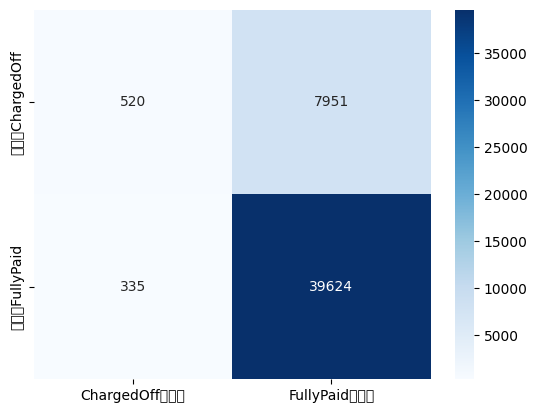

In [219]:
# heatmapによる混同行列の可視化
sns.heatmap(df_cm, annot=True, fmt="2g", cmap='Blues')
plt.yticks(va='center')
